# Globant's Data Science Test Case

## Candidate: Lucas Massaroppe

### Forecasting Expenditures of Purchase Card Transactions for the Birmingham City Council

#### A Disclaimer

Before running the code below, make sure the system has the libraries
 - PyStan, version 2.19.1.1;
 - Facebook Prophet;
 - plotly;

properly installed with the command lines
```
conda install pystan==2.19.1.1
conda install -c conda-forge prophet
conda install plotly
```

In this [dataset](https://data.birmingham.gov.uk/dataset/purchase-card-transactions) we can encounter a historical dataset wich spans from April/2014 to January/2018 of diverse expenditures of purchase card transactions.

What caught our attention when performing a simple analysis (that is, just looking at the graphs) of the columns is that the variables ```ORIGINAL GROSS AMT``` and ```BILLING GROSS AMT``` had their regularities and seasonality very well behaved and, therefore, we opted to explorer them more in-depth as time series and, thus, make the prediction and forecast of the first one in a suitable time window and forecast horizon, respectively.

Next, we will present the analysis as follows: we will build it together with the Python code starting with the import of all necessary libraries we will use to load, manipulate, analyze and model our data.

In [1]:
# data manipulation libraries
import os
import numpy as np
import pandas as pd
import glob as glob

# facebook prophet library
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

# datetime libraries
import datetime
from datetime import datetime, timedelta
from dateutil.relativedelta import *

# ploting libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_theme(style = 'darkgrid')
sns.set_context('notebook', font_scale = 1.5, rc = {"lines.linewidth": 3.0, "lines.markersize": 18.0})
%matplotlib inline

# turning off warnings
import warnings
warnings.filterwarnings("ignore")

Next we build two auxiliary functions two help us with our main routine. The first, ```fb_prophet()```, is an encapsulation for all the necessary methods of the Facebook Prophet's prediction algorithm wich is our choice between several others, such as SARIMAX, Holt Winters and VAR. The last function, ```mape()```, is a merit figure for measuring the model's error.

A pertinent observation regarding the Mean Absolute Percentage Error (MAPE) is that it is a metric more appropriate to present to the business area, since standardized and varies from $0$ to $100\%$ and, therefore, its interpretation is more simplified. Thus, when this percentage is a low number, e.g. $mape(true \ time \ series, predicted \ time \ series) < 10\%$, the fitted model presents a high goodness of fit and, as a consequence, it will have good skill of predicting future values.

In [2]:
def fb_prophet(df, h, p):
    '''
    Function to create a Facebook Prophet forecasting model
    
    Inputs:
    
    df: input dataframe (MUST BE A DAILY DATA SET)
    h:  forecast horizon
    p:  p = 1 - alpha, where alpha is the confidence level (type 1 error)
    
    Outputs:
    
    m:        Facebook Prophet forecasting model
    forecast: object with a dataframe that includes a column the forecast,
               as well as columns for components and uncertainty intervals
    e:        forecast mean absolute percentage error (MAPE)
    
    Author: Lucas Massaroppe
      Date: 2021-05-13
    '''
    
    # converting dataframe to a properly FB Prophet input
    ds = df.index               # date time stamp
    y  = df.iloc[ : , 0].values # input time series
    x1 = df.iloc[ : , 1].values
    del df
    dict = {
             'ds': ds
           , 'y' : y
           , 'x1': x1
           }
    df = pd.DataFrame(dict)
    
    # fit the model 'm' by instantiating a new Prophet object
    m = Prophet(                                    # 1) build the model
                seasonality_mode    = 'multiplicative'
              , yearly_seasonality  = True
              , weekly_seasonality  = True
              , daily_seasonality   = True
              , interval_width      = p
               )
    m.add_country_holidays(country_name = 'GB')     # 2) add britsh national holidays
    m.fit(df)                                       # 3) fit the model to the data set (df)
    
    # create a suitable dataframe that extends into the future a specified forecast horizon
    # using the helper method Prophet.make_future_dataframe
    future = m.make_future_dataframe(periods = h, freq = 'D')
    
    # create in and out of sample trying to predict/reproduce the data set and with intent to
    # forecast the next h steps after the final data point within the data set
    forecast = m.predict(future)
    
    # forecasted time series
    y_hat = forecast.yhat
    
    # forecast mean absolute percentage error
    e = mape(y, y_hat[ : -h])
    
    return m, forecast, e

def mape(y, y_hat):
    '''
    Function to evaluate the forecast Mean Absolute Percentage Error (MAPE)
    
    Inputs:
    
    y    : ground true series
    y_hat: forecasted series
    
    Output
    
    e: mean absolute percentage error
    
    Author: Lucas Massaroppe
    Date: 2021-05-13
    '''
    # making sure that both series 'y' and 'y_hat' are in NumPy format
    y, y_hat = np.array(y), np.array(y_hat)
    
    # evaluating the mean absolute percentage error
    perc_err = np.nanmean(np.abs((y - y_hat) / y)) * 100
    
    return perc_err

At this point we load all the data set from the historical purchase card transactions for the Birmingham City Council, from April/2014 to January/2018.

In [3]:
all_data = pd.DataFrame()
for i in glob.glob('/home/lucasmassaroppe/Documents/teste/historical_purchase_card_transactions_201404_201801/purchase*.xls'):
    df = pd.read_excel(i)
    all_data  = all_data.append(df, ignore_index = True)
    
del df

df = all_data.groupby(by = 'TRANS DATE').sum()
df.drop(columns = ['geom'], inplace = True)

del all_data

The task chosen to be performed was to try to guess future transactional behaviors, in terms of expenditures forecasting.

First of all, we checked the eligible data for possible outliers and a suitable time window in which the analysis will take place.

For that, we plotted and statistically described the following variables:
 - ```ORIGINAL GROSS AMT```
 - ```BILLING GROSS AMT```
 - ```TRANS TAX AMT```

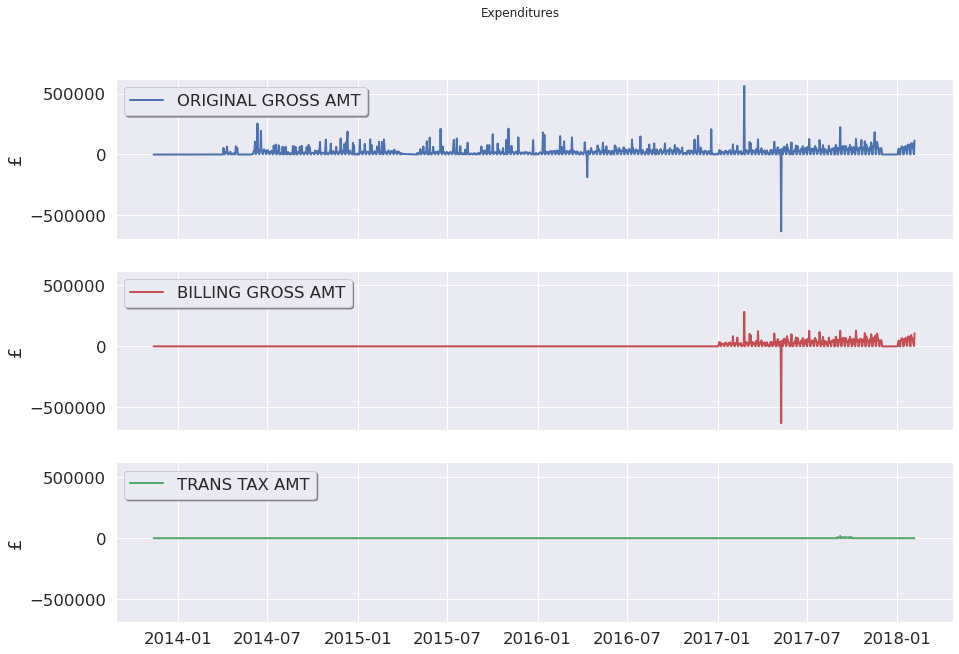

In [4]:
fig, axs = plt.subplots(3, sharex = True, sharey = True, figsize = (15,10))
fig.suptitle('Expenditures')
axs[0].plot(df.index, df.iloc[ : , 0], color = 'b', linewidth = 2, label = 'ORIGINAL GROSS AMT')
axs[0].legend(shadow = True, fancybox = True, loc = 'upper left')
axs[1].plot(df.index, df.iloc[ : , 1], color = 'r', linewidth = 2, label = 'BILLING GROSS AMT')
axs[1].legend(shadow = True, fancybox = True, loc = 'upper left')
axs[2].plot(df.index, df.iloc[ : , 2], color = 'g', linewidth = 2, label = 'TRANS TAX AMT')
axs[2].legend(shadow = True, fancybox = True, loc = 'upper left')

for ax in axs.flat:
    ax.set(ylabel = chr(163))

In [5]:
df.describe()

,ORIGINAL GROSS AMT,BILLING GROSS AMT,TRANS TAX AMT
count,1332.000000,1332.000000,1332.000000
mean,24649.245916,8452.142710,118.292222
std,39088.273088,27914.198262,991.093378
min,-630874.460000,-630925.330000,0.000000
25%,2255.857500,0.000000,0.000000
50%,16893.290000,0.000000,0.000000
75%,31768.195000,1088.390000,0.000000
max,562479.650000,283045.310000,18913.410000


As depicted on the plots it is clear that the ```ORIGINAL GROSS AMT``` and ```BILLING GROSS AMT``` have periods in comom from 2017-01-01 on. However records of ```TRANS TAX AMT``` dates on period beteween 2017-08-01 and 2017-11-01.

On the other hand, observing the statistics of the considered random variables and, also, by observing the ploted graphs, we see that there exists some outliers in the series. This is not a problem, because the considered forecasting algorithm, has robust regression estimators built in, such as Hubber's, and, therefore, is immune to these outliers.

Between this and that, we chose that the variables to be analyzed so that a forecast of expenditures can be made using ```ORIGINAL GROSS AMT``` in conjunction with ```BILLING GROSS AMT```, in the period from 2017-01-01 onwards.

The snippet of code below is able to do what was described in the previous paragraph and, also, forecasts for a forecast horizon of 365 days ahead and calculate the MAPE.

In [6]:
# Choosing: 
# - the time window in which the analysis will take place: 'df['2017-01-01' : ]'
# - wich variables: .iloc[ : , [0, 1])
# - and making a pre-processing to make the varibles stationary: apply the 
#   natural logarithm 'np.log()'
dff = np.log(df['2017-01-01' : ].iloc[ : , [0, 1]])

h = 1 * 365 # forecasting horizon: 365 days ahead
p = 0.99    # p = 1 - alpha, where alpha is the confidence level (type 1 error)

# function to calculate Facebook Prophet forecasting model
m, forecast, e = fb_prophet(dff, h, p)

# printing the forecast mean absolute percentage error (MAPE)
print(f'mape(true time series, predicted time series) = {e:.3f}%')

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


mape(true time series, predicted time series) = 4.603%


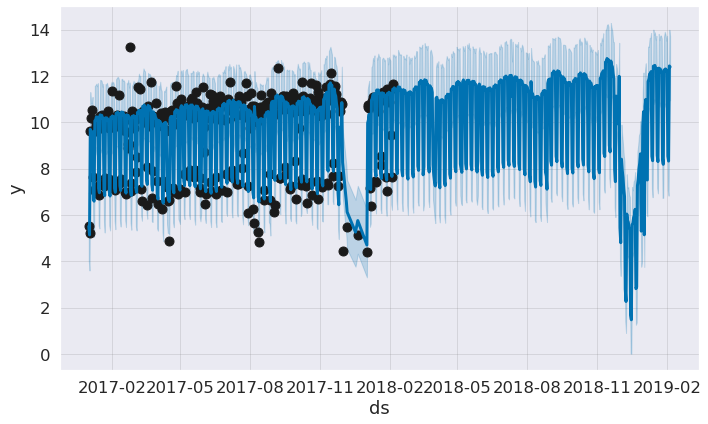

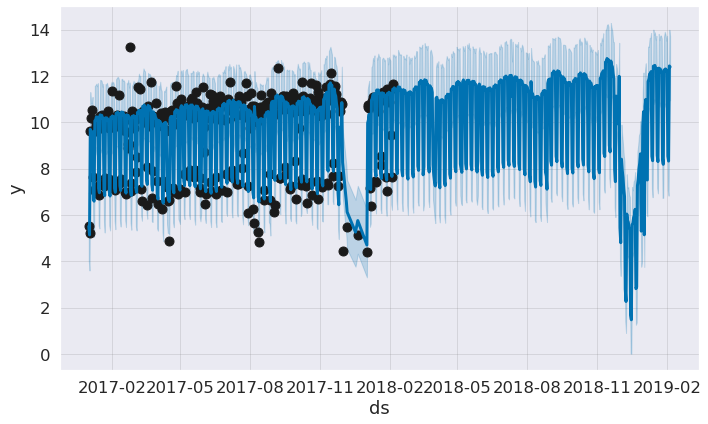

In [7]:
m.plot(forecast)

As depicted by the results, we see that the model has a good fit with the dataset on the period where the analysis took place, in which the vale MAPE between the true value of the ```ORIGINAL GROSS AMT``` time series and the predicted one was ```4.6\%```, below the threshold of ```10\%``` imposed by this analyst.

Moreover, as the plots show, the forecast for the next 365 days is consistent with the historical data, as it follows the same daily, weekly and annual seasonality, and trend pattern, even on days when expenditures are lower.

Recalling that to obtain the expenditures on the original scale, it is enough to invert the transformation, applying the exponential function ```exp()``` to the forecast, without loss of generality.